# cleaned_all_phones dataset (Using Sklearn and Keras)

##Importing Necessary Libraries

In [608]:
import math

# Data handling and stuff
import pandas as pd
import numpy as np
import tensorflow as tf

# Neural Network Magic Libraries (TensorFlow/Keras)
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, Nadam, AdamW
from keras.losses import Huber
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras import Input

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
# Visualization - remove if not used
import matplotlib.pyplot as plt
# import seaborn as sns

Tensorflow/Keras: 3.8.0


##Visualization Formatting

In [609]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## Data Acquisition and Preprocessing
##### Importing and Cleaning initial Dataset for Processing

In [610]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [611]:
# np.random.seed(42)

In [612]:
# smartphones = read_csv("CSVs Cleaned\Cleaned cleaned_all_phones.csv")
smartphones = read_csv("Cleaned cleaned_all_phones.csv")
cleaned_smartphones = clean_data(smartphones)
cleaned_smartphones.head()
cleaned_smartphones.info()

y = cleaned_smartphones["price"]
X = cleaned_smartphones.drop("price", axis=1)


categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    te = TargetEncoder(target_type="continuous", random_state=42, smooth = 'auto')
    data_array = X[col].values.reshape(-1, 1)
    X[col] = te.fit_transform(X[[col]], y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              1399 non-null   object 
 1   os                 1399 non-null   object 
 2   inches             1399 non-null   float64
 3   battery            1399 non-null   int64  
 4   battery_type       1399 non-null   object 
 5   ram(GB)            1399 non-null   int64  
 6   announcement_date  1399 non-null   object 
 7   weight(g)          1399 non-null   float64
 8   storage(GB)        1399 non-null   int64  
 9   video_720p         1399 non-null   bool   
 10  video_1080p        1399 non-null   bool   
 11  video_4K           1399 non-null   bool   
 12  video_8K           1399 non-null   bool   
 13  video_30fps        1399 non-null   bool   
 14  video_60fps        1399 non-null   bool   
 15  video_120fps       1399 non-null   bool   
 16  video_240fps       1399 

##Building our Feedforward Neural Network

##### Splitting training and testing samples

In [613]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scaling our Data for Processing

In [614]:
# Scale Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# Scale Target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [615]:
def predict_price_with_margin(model, scaler, X_data):
    """Returns predictions with dollar margins"""
    scaled_pred = model.predict(X_data)
    pred_dollars = scaler.inverse_transform(scaled_pred).flatten()
    mae_dollars = mean_absolute_error(
        scaler.inverse_transform(y_test_scaled).flatten(),
        pred_dollars
    )
    return pred_dollars, mae_dollars


##### Defining the Structure of the Neural Network

In [616]:
model = Sequential(name="Smartphones_NN")
model.add(Input(shape=(X_train_scaled.shape[1],)))# Input Layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3)) # Deactivates % of neurons if they are not improving performance
model.add(Dense(64, activation='relu')) # Hidden Layer 2
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu')) # Hidden Layer 3
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1)) # Output Layer

##### Compile Keras model aka Magic

In [617]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=Huber(delta=1.0),  # Handles Outliers better than mse
    metrics=['mae']
)

In [618]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

X_train_scaled shape: (1119, 24)
y_train_scaled shape: (1119, 1)


##### Fitting keras model onto the dataset

In [619]:
batch_size = 64
early_stop = EarlyStopping(monitor='val_mae', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.2,         # Reduce LR by 50%
    patience=10,         # Wait 5 epochs w/o improvement before reducing LR
    min_lr=1e-4,        # Smallest allowed LR
    verbose=1           # Print a message when LR changes
)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=200,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr, early_stop])


# model.fit(X_train_scaled, y_train_scaled, batch_size=batch_size,steps_per_epoch=steps_per_epoch, epochs=10)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7282 - mae: 1.1256 - val_loss: 0.3501 - val_mae: 0.7135 - learning_rate: 0.0050
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4276 - mae: 0.7903 - val_loss: 0.3319 - val_mae: 0.6861 - learning_rate: 0.0050
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3999 - mae: 0.7613 - val_loss: 0.3310 - val_mae: 0.6746 - learning_rate: 0.0050
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3550 - mae: 0.7008 - val_loss: 0.3200 - val_mae: 0.6595 - learning_rate: 0.0050
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3388 - mae: 0.6771 - val_loss: 0.3200 - val_mae: 0.6619 - learning_rate: 0.0050
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3312 - mae: 0.6761 - val_loss: 0.3218 - val_mae: 0.6536 - learning_rate: 0.0050
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3443 - mae: 0.6823 - val_loss: 0.3186 - val_mae: 0.6498 - learning_rate: 0.0050
Epoch 8/20

##### Making Predictions with our model

Evaluating model

In [620]:
# Get your scaled test predictions
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform BOTH predictions and true values
y_pred_dollars = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_dollars = scaler_y.inverse_transform(y_test_scaled).flatten()

# Calculate MAE in original dollars
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae:.4f}")
mae_dollars = mean_absolute_error(y_true_dollars, y_pred_dollars)

print(f"Official Test MAE (USD): ±${mae_dollars:.2f}")
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true_dollars, y_pred_dollars):.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MAE: 0.6259
Official Test MAE (USD): ±$89.01
Mean Absolute Percentage Error: 0.35


###### K-Fold Cross Validation to Debug model (3)

In [621]:
# # Initialize KFold (use same random_state as your train_test_split for consistency)
# kf = KFold(n_splits=3, shuffle=True, random_state=0)
# mae_scores, mape_scores = [], []

# clusters = KMeans(n_clusters=3).fit_predict(X)
# for fold, (train_idx, val_idx) in enumerate(StratifiedKFold(n_splits=3).split(X, clusters)):
#     print(f"\nFold {fold + 1}")

#     # Split raw data
#     X_train_raw, X_val_raw = X.iloc[train_idx], X.iloc[val_idx]
#     y_train_raw, y_val_raw = y.iloc[train_idx], y.iloc[val_idx]

#     # Scale features and target PER FOLD (critical!)
#     scaler_X = StandardScaler()
#     X_train_scaled = scaler_X.fit_transform(X_train_raw)
#     X_val_scaled = scaler_X.transform(X_val_raw)

#     scaler_y = StandardScaler()
#     y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
#     y_val_scaled = scaler_y.transform(y_val_raw.values.reshape(-1, 1))

#     # Build and train model (using your best config: Adam lr=0.005)
#     model = Sequential([
#         Input(shape=(X_train_scaled.shape[1],)),
#         Dense(128, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.4),
#         Dense(32, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(1)
#     ])

#     model.compile(optimizer=Adam(learning_rate=0.005), loss='mae', metrics=['mae'])

#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_mae',
#         factor=0.2,         # Reduce LR by 50%
#         patience=10,         # Wait 5 epochs w/o improvement before reducing LR
#         min_lr=1e-4,        # Smallest allowed LR
#         verbose=1           # Print a message when LR changes
#     )

#     history = model.fit(
#         X_train_scaled, y_train_scaled,
#         validation_data=(X_val_scaled, y_val_scaled),
#         epochs=100,
#         batch_size=64,
#         callbacks=[early_stop, reduce_lr],
#         verbose=0
#     )

#     # Evaluate and INVERSE TRANSFORM predictions to original USD scale
#     y_pred_scaled = model.predict(X_val_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)
#     mae = np.mean(np.abs(y_pred - y_val_raw.values.reshape(-1, 1)))
#     mape = np.mean(np.abs((y_val_raw.values - y_pred.flatten()) / y_val_raw.values)) * 100

#     mae_scores.append(mae)
#     mape_scores.append(mape)
#     print(f"Fold {fold + 1} | Test MAE: ${mae:.2f} | MAPE: {mape:.2f}%")

# print("\nFinal Metrics:")
# print(f"Mean MAE: ${np.mean(mae_scores):.2f} ± ${np.std(mae_scores):.2f}")
# print(f"Mean MAPE: {np.mean(mape_scores):.2f}% ± {np.std(mape_scores):.2f}%")

###### Bias Check

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Text(0.5, 1.0, 'Error Distribution')

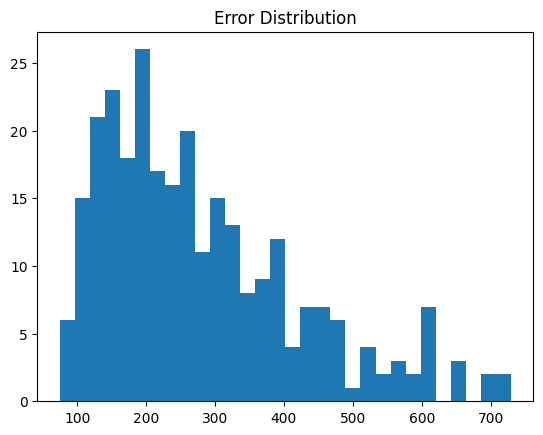

In [622]:
predictions = model.predict(X_test_scaled)
errors = y_test - predictions.flatten()
plt.hist(errors, bins=30)
plt.title("Error Distribution")

###### Prediction calculation

In [623]:
# Make predictions and compare with true values
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


##Plots

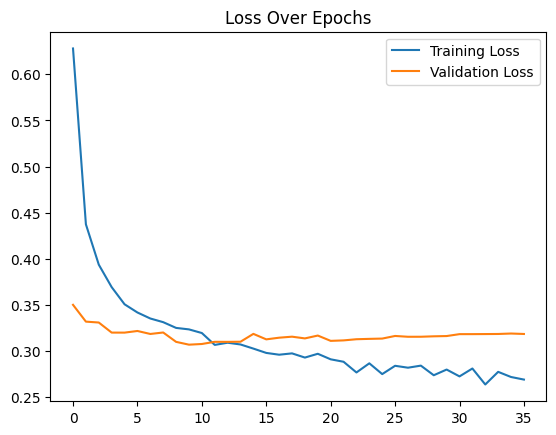

In [624]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()



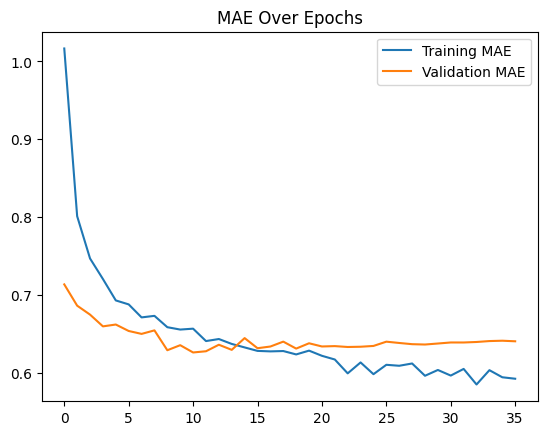

In [625]:
# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.show()

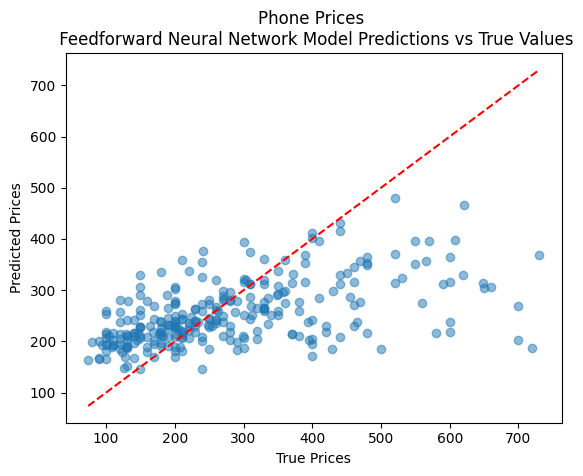

In [626]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Phone Prices \n Feedforward Neural Network Model Predictions vs True Values")
plt.show()

In [627]:
count = count + 1
if count > 30:
  print('Over 30')
  print('Avg MAE ', avg_mae/30*1.0)
  print('Avg MAPE ', avg_mape/30*1.0)
else:
  print('Clount = ', count)
  avg_mae = avg_mae + mae_dollars
  avg_mape = avg_mape + mean_absolute_percentage_error(y_test, y_pred)

Over 30
Avg MAE  89.62121197871616
Avg MAPE  0.3574637259281827
